In [18]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [19]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Please tell me how can I help you?", name="LLMModel")]
messages.append(HumanMessage(content=f"I want to start learning coding.", name="Human"))
messages.append(AIMessage(content=f"Sure, what programming language are you interested in?", name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn Python programming language.", name="Human"))

for message in messages: 
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help you?
================================ Human Message =================================
Name: Human

I want to start learning coding.
================================== Ai Message ==================================
Name: LLMModel

Sure, what programming language are you interested in?
================================ Human Message =================================
Name: Human

I want to learn Python programming language.


In [20]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")
results=llm.invoke(messages)

results.content
results.response_metadata


{'token_usage': {'completion_tokens': 1523,
  'prompt_tokens': 62,
  'total_tokens': 1585,
  'completion_time': 3.081480245,
  'prompt_time': 0.002779156,
  'queue_time': 0.19865538,
  'total_time': 3.084259401},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

In [21]:
def add(a:int, b: int) -> int: 
    """ Add a and b 
    Args: 
        a (int): first number 
        b (int): second number

    Returns:
        int: sum of a and b
    """
    return a + b 


In [22]:
## Bind the tool to the LLM 

llm_with_tools = llm.bind_tools([add])
results_with_tools=llm_with_tools.invoke([HumanMessage(content="What is the sum of 10 and 12?", name="Human")])
results_with_tools.tool_calls




[{'name': 'add',
  'args': {'a': 10, 'b': 12},
  'id': 'gzzmner04',
  'type': 'tool_call'}]

In [23]:
from typing_extensions import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages 

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]



In [24]:
## Reducers with add_messages

initial_messages = [AIMessage(content=f"Please tell me how can I help you?", name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to start learning coding.", name="Human"))

initial_messages

[AIMessage(content='Please tell me how can I help you?', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to start learning coding.', additional_kwargs={}, response_metadata={}, name='Human')]

In [27]:
## Reducers, add_messages is used to append instead of override. 

ai_message = (AIMessage(content=f"Sure, what programming language are you interested in?", name="LLMModel"))
appended_message = add_messages(initial_messages, ai_message)
appended_message

[AIMessage(content='Please tell me how can I help you?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='b2f775be-c40e-4301-80b1-ababa45ca16d'),
 HumanMessage(content='I want to start learning coding.', additional_kwargs={}, response_metadata={}, name='Human', id='1522219b-1c77-4348-90c1-cb240531bd65'),
 AIMessage(content='Sure, what programming language are you interested in?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='1f3d03af-1d26-43c2-bbcb-2336f243070e')]

In [ ]:
def llm_tools(state:State):
    return {"messages": llm_with_tools.invoke(state["messages"])}



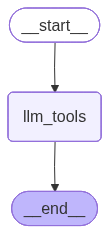

In [33]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END 

graph = StateGraph(State) 

graph.add_node("llm_tools", llm_tools) 
graph.add_edge(START, "llm_tools")
graph.add_edge("llm_tools", END)

graph_builder = graph.compile() 
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [35]:
#graph_builder.invoke({"messages": [HumanMessage(content="What is the sum of 20 and 22?", name="Human")]}) 
result_messages = graph_builder.invoke({"messages": "what is the sum of 20 and 22?"})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()
    


================================ Human Message =================================

what is the sum of 20 and 22?
================================== Ai Message ==================================
Tool Calls:
  add (6nnxxqgbc)
 Call ID: 6nnxxqgbc
  Args:
    a: 20
    b: 22


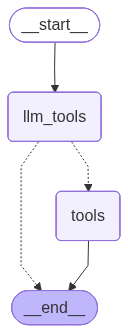

In [41]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

builder = StateGraph(State)
tools = [add]

## Add the nodes - 
builder.add_node("llm_tools", llm_tools)
builder.add_node("tools", ToolNode(tools))

## Add the edges - 
builder.add_edge(START, "llm_tools") 
builder.add_conditional_edges(
    "llm_tools", 
    ## if latest message from assistance is a tool call --> tools condition routes to tool. 
    ## if latest message from assistance is a not a tool call --> tools condition routes to End. 
    tools_condition
)

builder.add_edge("tools", END)

graph_builder = builder.compile() 
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [42]:
#graph_builder.invoke({"messages": [HumanMessage(content="What is the sum of 20 and 22?", name="Human")]}) 
result_messages = graph_builder.invoke({"messages": "what is the sum of 39 and 22?"})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()
    


================================ Human Message =================================

what is the sum of 39 and 22?
================================== Ai Message ==================================
Tool Calls:
  add (3r7rgc7vk)
 Call ID: 3r7rgc7vk
  Args:
    a: 39
    b: 22
================================= Tool Message =================================
Name: add

61


In [40]:
#graph_builder.invoke({"messages": [HumanMessage(content="What is the sum of 20 and 22?", name="Human")]}) 
result_messages = graph_builder.invoke({"messages": "What is machine learning?"})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()
    

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================

The provided tools do not include any functions that can explain or provide information about machine learning. However, I can answer your question directly.

Machine learning is a subset of artificial intelligence (AI) that involves building systems that can learn from data. Instead of being explicitly programmed to perform a task, a machine learning model improves its performance through experience. This is done by using algorithms that iteratively learn from data, allowing the system to find hidden insights and patterns without being explicitly programmed where to look. Common applications include image recognition, natural language processing, recommendation systems, and more.
